In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [75]:
class RealNVP(tf.keras.Model):
    def __init__(self, num_layers, input_dim):
        super().__init__()
        self.L = num_layers
        self.D = input_dim
        self.mask_list = [self.create_mask(flip=(i%2)) for i in range(self.L)]
        self.s_list = [self.create_s() for _ in range(self.L)]
        self.t_list = [self.create_t() for _ in range(self.L)]
        self.logdetJ = None

        #proposal distribution
        self.Rz = tfp.distributions.MultivariateNormalDiag(loc = np.zeros(self.D), 
                                                         scale_diag = np.ones(self.D))
    
    def call(self, y, forward=True):
        if forward:
            z = y
            x = self.forward_flow(z)
            z = tf.cast(z, dtype=tf.float64)
            ldj = tf.cast(self.Rz.log_prob(z),dtype=tf.float32) - self.logdetJ
            return x, ldj
        else:
            x = y
            # print(f'Input : {x.get_shape()}')
            z = self.reverse_flow(x)
            # print(f'Call z : {z.get_shape()}')
            z = tf.cast(z, dtype=tf.float64)
            # print(f'ldj : {self.logdetJ.get_shape()}')
            ldj = tf.cast(self.Rz.log_prob(z),dtype=tf.float32) + self.logdetJ
            return z, ldj

    def create_s(self):
        s = Sequential(
            layers = [ Dense(64, activation='relu', kernel_regularizer = l2(0.01)),
                       Dense(64, activation='relu', kernel_regularizer = l2(0.01)),
                       Dense(self.D, activation='relu', kernel_regularizer = l2(0.01))]   
        )
        return s
    
    def create_t(self):
        t = Sequential(
            layers = [ Dense(64, activation='relu', kernel_regularizer = l2(0.01)),
                       Dense(64, activation='relu', kernel_regularizer = l2(0.01)),
                       Dense(self.D, activation='relu', kernel_regularizer = l2(0.01))]       
        )
        return t
    
    def create_mask(self,flip=False):
        mask = tf.concat([np.ones((self.D//2,)),np.zeros((self.D-self.D//2,))],axis=0)
        if flip:
            mask = tf.reverse(mask, [0])
        return tf.cast(mask,dtype=tf.float32)

    def forward_flow(self, z):
        self.logdetJ = 0
        for i in range(self.L):
            mask = self.mask_list[i]
            z_ = z*mask
            s = self.list[i](z_)*(1-mask)
            t = self.t_list[i](z_)*(1-mask)
            x = z_ + tf.exp(s)*z*(1-mask) + t
            self.logdetJ -= tf.reduce_sum(s,[1])
            z = x
        return x

    def reverse_flow(self, x):
        self.logdetJ = 0
        for i in reversed(range(self.L)):
            mask = self.mask_list[i]
            # print(f'mask : {mask.get_shape()}')
            # print(x)
            x_ = x*mask
            # print(f'x_ : {x_.get_shape()}, {x_}')
            s = self.s_list[i](x_)*(1-mask)
            # print(f's : {s.get_shape()}')
            t = self.t_list[i](x_)*(1-mask)
            # print(f't : {t.get_shape()}')
            z = x_ + (x*(1-mask) - t)*tf.exp(-s)
            # print(f'z : {z.get_shape()}')
            self.logdetJ += tf.reduce_sum(s,[1])
            x = z
        return z

    def log_loss(self, y, forward=True):
        z, ldj = self(y, forward=forward)
        z = tf.cast(z, dtype=tf.float64)
        log_likelihood = tf.cast(self.Rz.log_prob(z),dtype=tf.float32) + ldj
        return -tf.reduce_mean(log_likelihood)

2023-06-17 21:13:38.626213: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(3000, 2) tf.Tensor([-1.035856   1.4273229], shape=(2,), dtype=float32)


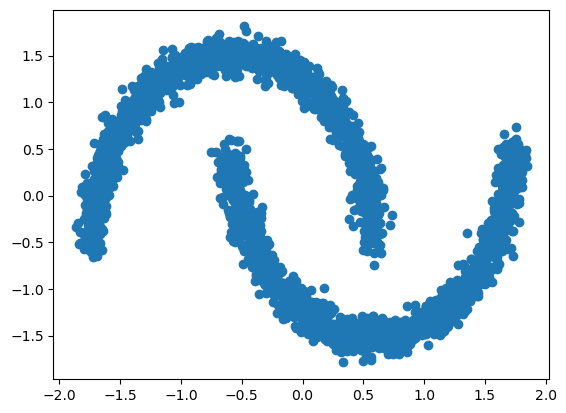

In [4]:
data = make_moons(3000, noise=0.05)[0].astype('float32')
norm = tf.keras.layers.Normalization()
norm.adapt(data)
norm_data = norm(data)
print(norm_data.shape, norm_data[0])

plt.scatter(norm_data[:,0], norm_data[:,1])
plt.show()   

In [79]:
train_data = tf.data.Dataset.from_tensor_slices(norm_data).batch(20)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
loss_tracker = tf.keras.metrics.Mean(name="loss")

In [83]:
model = RealNVP(2, 2)

In [81]:
# res_data = tf.expand_dims(norm_data[0],axis=1)
# print(res_data.get_shape())
z,ldj = model(norm_data[:3], forward=False)
print(z)
print(ldj)

tf.Tensor(
[[-1.34649503  1.42732286]
 [-1.14757621  1.44914961]
 [ 1.38885224 -0.68663472]], shape=(3, 2), dtype=float64)
tf.Tensor([-3.7630267 -3.54636   -3.038066 ], shape=(3,), dtype=float32)


In [84]:
epochs = 10

for e in range(epochs):
    losses = []
    for step, batch in enumerate(train_data):
        with tf.GradientTape() as tape:
            loss = model.log_loss(batch, forward=False)

        grad = tape.gradient(loss, model.trainable_variables)  
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
        loss_tracker.update_state(loss)  
        losses.append(loss)
    
    train_loss = np.mean(np.array(losses))
    print(f'Epoch {e+1} train_loss = {train_loss}')    

Epoch 1 train_loss = 4.374973773956299
Epoch 2 train_loss = 2.4198672771453857
Epoch 3 train_loss = -1.6355059146881104
Epoch 4 train_loss = -17.000713348388672
Epoch 5 train_loss = -59.43460464477539
Epoch 6 train_loss = -148.5248565673828
Epoch 7 train_loss = -312.84405517578125
Epoch 8 train_loss = -589.9617919921875
Epoch 9 train_loss = -1022.2001953125
Epoch 10 train_loss = -1661.50732421875


(-2.0, 2.0)

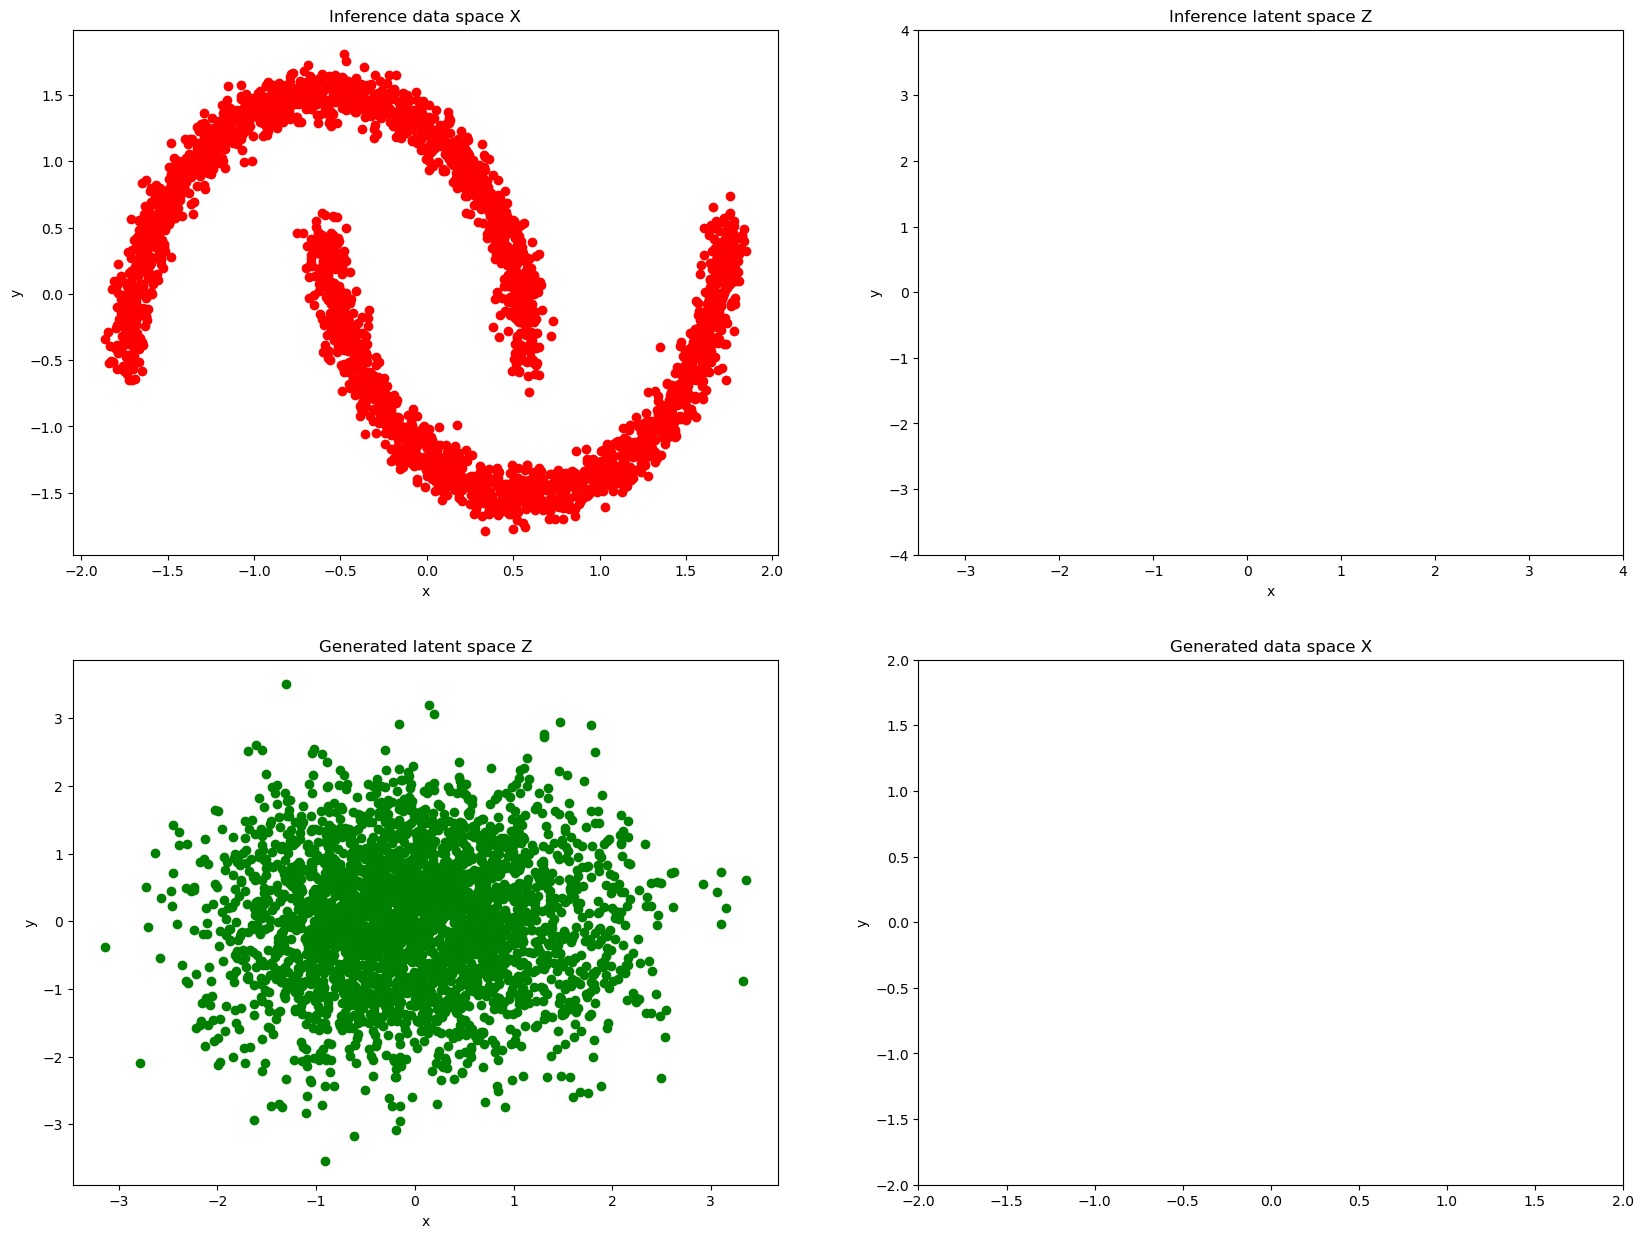

In [89]:
# From data to latent space.
z, _ = model(norm_data, forward=False)

# From latent space to data.
samples = tf.cast(model.Rz.sample(3000),dtype=tf.float32)
x = model.reverse_flow(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(norm_data[:, 0], norm_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])